# Comparison between `ROSE` and `jitr`

We will use the high-fidelity solver in the [`ROSE` package](https://github.com/bandframework/rose). It is avilable on [pypi](https://pypi.org/project/nuclear-rose/) 

In [1]:
#!pip install nuclear-rose
import rose

In [2]:
from pathlib import Path

import corner

# import stuff for nice plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from numba import njit
from scipy import stats
from tqdm import tqdm

import jitr

In [3]:
Ca48 = (48, 20)
proton = (1, 1)

angles = np.linspace(0.1, np.pi, 100)

In [4]:
Elab = 35
reaction = jitr.reactions.ElasticReaction(target=Ca48, projectile=proton)
kinematics = jitr.utils.kinematics.classical_kinematics(
    reaction.target.m0,
    reaction.projectile.m0,
    Elab,
    reaction.target.Z * reaction.projectile.Z,
)
channel_radius = jitr.utils.suggested_dimensionless_channel_radius(
    jitr.utils.interaction_range(reaction.target.A), kinematics.k
)
jitr.utils.suggested_basis_size(channel_radius, zeros_per_node=10)

40

In [5]:
ws = jitr.xs.elastic.DifferentialWorkspace.build_from_system(
    reaction=reaction,
    kinematics=kinematics,
    channel_radius_fm=channel_radius / kinematics.k,
    solver=jitr.rmatrix.Solver(40),
    lmax=20,
    angles=angles,
)

In [6]:
def interaction_central(r, params_coul, params_kd):
    coul = jitr.optical_potentials.potential_forms.coulomb_charged_sphere(r, *params_coul)
    nucl = jitr.optical_potentials.kduq.central(r, *params_kd)
    return coul + nucl

In [9]:
kduq = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=kinematics.mu,
    energy=kinematics.Ecm,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=1,
    Z_2=Ca48[1],
    R_C=4.273283849175178,
    l_max=50,
)
kduq_rose_solver = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    kduq,
    base_solver=rose.LagrangeRmatrix(
        kduq.interactions[0][0],
        channel_radius,
        jitr.rmatrix.Solver(100),
    ),
    angles=angles,
    s_mesh=np.linspace(0.01, channel_radius, 1000),
)

In [10]:
# we have 416 samples from the KDUQ posterior
num_samples_kduq = 415
param_files = [
    jitr.data_dir / f"KDUQFederal/{i}/parameters.json"
    for i in range(0, num_samples_kduq)
]

# load each one
rose_omps = [
    rose.koning_delaroche.KDGlobal(rose.Projectile.proton, Path(param_file))
    for param_file in param_files
]
# load each one
jitr_omps = [
    jitr.optical_potentials.kduq.Global(proton, Path(param_file)) for param_file in param_files
]

In [11]:
coulomb_params, central_params, spin_orbit_params = jitr_omps[7].get_params(
    *Ca48, kinematics.Elab,
)

In [12]:
R_c, params = rose_omps[7].get_params(*Ca48, kinematics.mu, kinematics.Elab, kinematics.k)

In [13]:
R_c - coulomb_params[1]

0.0

In [14]:
params[-len(spin_orbit_params) :] - spin_orbit_params

array([0., 0., 0., 0., 0., 0.])

In [15]:
params[: len(central_params)] - central_params

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
R_c

4.273283849175178

Text(0, 0.5, '$V(s)$')

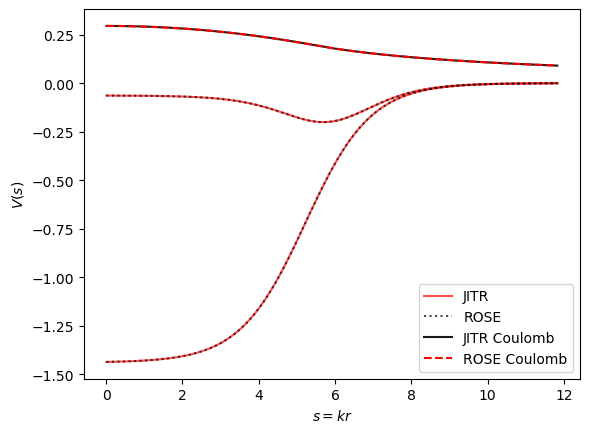

In [19]:
s = np.linspace(0.01, channel_radius, 500)
Elab, Ecm, mu, k, eta = kinematics
l = 0
ij = 0
rose_int = kduq.interactions[l][ij]
l_dot_s = rose_int.spin_orbit_term.l_dot_s

Vrose = (
    rose_int.v_r(s / k, params) / Ecm
    + rose_int.spin_orbit_term.v_so(s / k, params, l_dot_s) / Ecm
)
Vcoul_rose = 2 * eta * rose.utility.regular_inverse_s(s, R_c * k)

Vjitr = (
    jitr.optical_potentials.kduq.central(s / k, *central_params) / Ecm
    + jitr.optical_potentials.kduq.spin_orbit(s / k, *spin_orbit_params) * l_dot_s / Ecm
)
Vcoul_jitr = (
    jitr.optical_potentials.potential_forms.coulomb_charged_sphere(s / k, *coulomb_params) / Ecm
)

plt.plot(s, Vjitr.real, "r", label="JITR", alpha=0.7)
plt.plot(s, Vjitr.imag, "r", alpha=0.7)

plt.plot(s, Vrose.real, "k:", label="ROSE", alpha=0.7)
plt.plot(s, Vrose.imag, "k:", alpha=0.7)

plt.plot(s, Vcoul_jitr, "k", label="JITR Coulomb", alpha=0.9)
plt.plot(s, Vcoul_rose, "r--", label="ROSE Coulomb")

plt.legend()
plt.xlabel(r"$s = kr$")
plt.ylabel(r"$V(s)$")

In [20]:
spr, smr = kduq_rose_solver.exact_smatrix_elements(params)

In [25]:
spj, smj = ws.integral_workspace.smatrix(
    jitr.optical_potentials.kduq.central_plus_coulomb,
    jitr.optical_potentials.kduq.spin_orbit,
    args_central=(central_params,coulomb_params),
    args_spin_orbit=spin_orbit_params,
)

In [27]:
smr - smj

array([ 0.00000000e+00+0.00000000e+00j,  9.62078365e-07+9.41609282e-07j,
        2.18721046e-07+4.75137477e-06j, -1.61839001e-06-1.03257254e-06j,
        2.82837234e-06-3.65673320e-06j, -1.05522563e-06-3.07695775e-06j,
       -1.69760474e-07-2.02590070e-07j,  4.07079456e-08-5.11617106e-08j,
        7.02774205e-09-1.11750697e-08j,  6.17301099e-10-1.06665136e-09j,
        3.88659105e-11+1.05659509e-10j,  1.62159175e-12+1.03943683e-10j,
       -5.55111512e-15+4.01324014e-11j, -1.21014310e-14+1.14786539e-11j,
       -1.55431223e-15+2.61144129e-12j, -1.11022302e-16+5.19770197e-13j])

In [28]:
spr - spj

array([-2.02329324e-06-2.02096739e-06j,  1.06867816e-06+7.33286908e-07j,
       -1.06318928e-06+5.09761858e-06j, -1.38161446e-06-1.40245934e-06j,
        2.84392249e-06-1.00989216e-06j,  2.92856123e-06-4.40362177e-06j,
       -6.02965147e-07-9.44229141e-07j,  1.33407948e-08-5.26898567e-08j,
        8.24611435e-09-1.31616266e-08j,  7.81780862e-10-1.40272678e-09j,
        4.99517094e-11+9.89489810e-11j,  2.23643326e-12+1.03113395e-10j,
        2.37587727e-14+3.97923116e-11j, -1.18793864e-14+1.21009961e-11j,
       -2.10942375e-15+2.59922025e-12j, -2.22044605e-16+5.02096854e-13j])

In [30]:
xs_jitr = ws.xs(
    jitr.optical_potentials.kduq.central_plus_coulomb,
    jitr.optical_potentials.kduq.spin_orbit,
    args_central=(central_params,coulomb_params),
    args_spin_orbit=spin_orbit_params,
)

In [31]:
xs_rose = kduq_rose_solver.exact_xs(params)

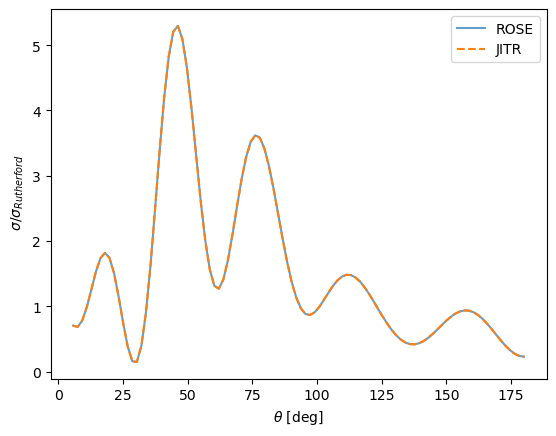

In [32]:
plt.plot(
    angles * 180 / np.pi,
    xs_rose.dsdo,
    alpha=0.7,
    label="ROSE",
)
plt.plot(angles * 180 / np.pi, xs_jitr.dsdo / ws.rutherford, "--", label="JITR")

# plt.yscale("log")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r" $\sigma / \sigma_{Rutherford}$")
plt.legend()
# plt.xlim([10,50])

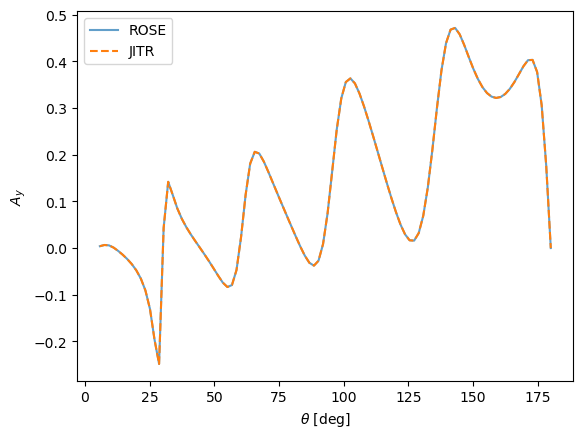

In [33]:
plt.plot(angles * 180 / np.pi, xs_rose.Ay, alpha=0.7, label="ROSE")
plt.plot(angles * 180 / np.pi, xs_jitr.Ay, "--", label="JITR")

# plt.yscale("log")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$A_y$")
plt.legend()
# plt.xlim([10,50])

In [35]:
np.testing.assert_allclose(smj, smr, atol=0.03)
np.testing.assert_allclose(spj, spr, atol=0.03)

In [36]:
np.testing.assert_allclose(xs_rose.dsdo, xs_jitr.dsdo / ws.rutherford, atol=2e-2)
np.testing.assert_allclose(xs_rose.Ay, xs_jitr.Ay, atol=0.03)

In [37]:
ws.ls.shape

(21, 1)

In [38]:
ws.ls[:10, :].shape

(10, 1)

In [39]:
np.sum(ws.ls * ws.P_l_costheta, axis=0).shape

(100,)